In [85]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt

In [86]:
# Your client credentials
client_id = 'a4e8861d-57bc-42f8-9589-0761f7dec0df'
client_secret = "&q3KfZgvi/%[rGz6>:rYwC0s^!ALn#W^wUxo7Aqc"


# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_secret=client_secret)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")
print(resp.content)

def sentinelhub_compliance_hook(response):
    response.raise_for_status()
    return response

oauth.register_compliance_hook("access_token_response", sentinelhub_compliance_hook)

b'{"sub":"b3d04095-4472-4352-9580-e97cb48baabc","aud":"a4e8861d-57bc-42f8-9589-0761f7dec0df","jti":"7d7dccfb-040e-40eb-9491-576181d219b6","exp":1679494221,"name":"Simon Volden","email":"simonvolden@gmail.com","given_name":"Simon","family_name":"Volden","sid":"96e75c50-7d3f-456b-9ca2-02eae95088f7","did":1,"aid":"df8d1dad-4797-4175-9446-701a168acc98","d":{"1":{"ra":{"rag":1},"t":11000}},"active":true}'


In [87]:
bbox = [5.9, 62.6010, 6.2665, 62.4351]
start_date = "2023-01-10T00:00:00Z"
end_date = "2023-03-20T23:59:59Z"
collection_id = "sentinel-2-l2a"

In [88]:
evalscript = """//VERSION=3

function setup() {
    return {
        input: ["B04", "B08", "SCL","dataMask"],
        output: [
			{ id: "default", bands: 4 },
			{ id: "index", bands: 1, sampleType: "FLOAT32" },
            { id: "eobrowserStats", bands: 2, sampleType: 'FLOAT32' },
            { id: "dataMask", bands: 1 }
		]
      };
}

function evaluatePixel(samples) {
    let val = index(samples.B08, samples.B04);
    let imgVals = null;
    // The library for tiffs works well only if there is only one channel returned.
    // So we encode the "no data" as NaN here and ignore NaNs on frontend.
    const indexVal = samples.dataMask === 1 ? val : NaN;
  
    if (val<-0.5) imgVals = [0.05,0.05,0.05,samples.dataMask];
    else if (val<-0.2) imgVals = [0.75,0.75,0.75,samples.dataMask];
    else if (val<-0.1) imgVals = [0.86,0.86,0.86,samples.dataMask];
    else if (val<0) imgVals = [0.92,0.92,0.92,samples.dataMask];
    else if (val<0.025) imgVals = [1,0.98,0.8,samples.dataMask];
    else if (val<0.05) imgVals = [0.93,0.91,0.71,samples.dataMask];
    else if (val<0.075) imgVals = [0.87,0.85,0.61,samples.dataMask];
    else if (val<0.1) imgVals = [0.8,0.78,0.51,samples.dataMask];
    else if (val<0.125) imgVals = [0.74,0.72,0.42,samples.dataMask];
    else if (val<0.15) imgVals = [0.69,0.76,0.38,samples.dataMask];
    else if (val<0.175) imgVals = [0.64,0.8,0.35,samples.dataMask];
    else if (val<0.2) imgVals = [0.57,0.75,0.32,samples.dataMask];
    else if (val<0.25) imgVals = [0.5,0.7,0.28,samples.dataMask];
    else if (val<0.3) imgVals = [0.44,0.64,0.25,samples.dataMask];
    else if (val<0.35) imgVals = [0.38,0.59,0.21,samples.dataMask];
    else if (val<0.4) imgVals = [0.31,0.54,0.18,samples.dataMask];
    else if (val<0.45) imgVals = [0.25,0.49,0.14,samples.dataMask];
    else if (val<0.5) imgVals = [0.19,0.43,0.11,samples.dataMask];
    else if (val<0.55) imgVals = [0.13,0.38,0.07,samples.dataMask];
    else if (val<0.6) imgVals = [0.06,0.33,0.04,samples.dataMask];
    else imgVals = [0,0.27,0,samples.dataMask];    
  	
  	return {
      default: imgVals,
      index: [indexVal],
      eobrowserStats:[val,isCloud(samples.SCL)?1:0],
      dataMask: [samples.dataMask]
    };
}

function isCloud (scl) {
  if (scl == 3) { // SC_CLOUD_SHADOW
    return false;
  } else if (scl == 9) { // SC_CLOUD_HIGH_PROBA
    return true; 
  } else if (scl == 8) { // SC_CLOUD_MEDIUM_PROBA
    return true;
  } else if (scl == 7) { // SC_CLOUD_LOW_PROBA
    return false;
  } else if (scl == 10) { // SC_THIN_CIRRUS
    return true;
  } else if (scl == 11) { // SC_SNOW_ICE
    return false;
  } else if (scl == 1) { // SC_SATURATED_DEFECTIVE
    return false;
  } else if (scl == 2) { // SC_DARK_FEATURE_SHADOW
     return false;
  }
  return false;
}"""

In [97]:
json_request = {
  "input": {
    "bounds": {
      "bbox": bbox,
      'properties': {
                'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'
                }
    },
    "data": [
      {
        "dataFilter": {
          "timeRange": {
            "from": start_date,
            "to": end_date
          },
          "maxCloudCoverage": "100"
        },
        "type": "sentinel-2-l2a"
      }
    ]
  },
  "output": {
    "width": 2048,
    "height": 2048,
    "responses": [
      {
        "identifier": "default",
        "format": {
          "type": "image/jpeg"
        }
      }
    ]
  },
"evalscript": evalscript
}

In [98]:
# Set the request url and headers
url_request = 'https://services.sentinel-hub.com/api/v1/process'
headers_request = {
    "Authorization" : "Bearer %s" %token['access_token']
}

#Send the request
response = oauth.request(
    "POST", url_request, headers=headers_request, json = json_request
)


In [99]:
response

<Response [200]>

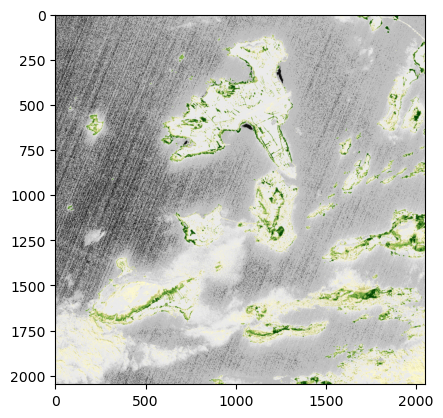

In [100]:
# read the image as numpy array
image_arr = np.array(Image.open(io.BytesIO(response.content)))

# plot the image for visualization
plt.imshow(image_arr)